# Camera Calibration

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping
import glob

Text(0.5,1,'Undistorted Image')

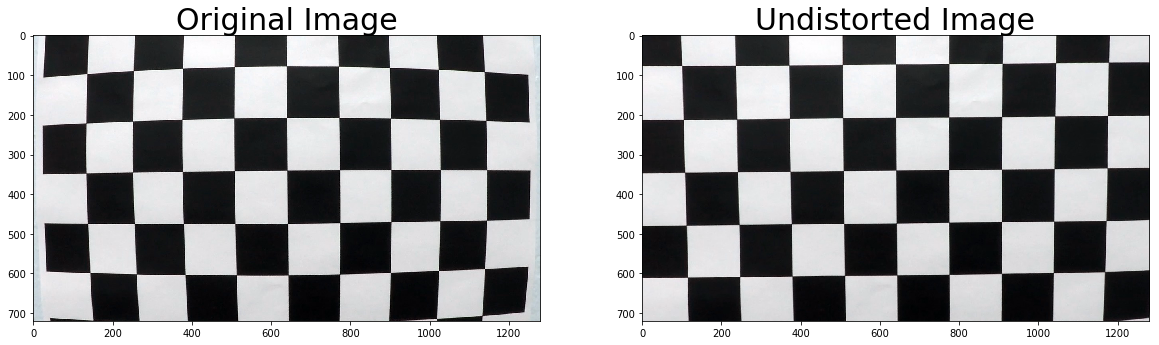

In [6]:
#define the chessboard's point
nx = 9
ny = 5

#prepare object point, like (0, 0, 0), (1, 0, 0), (2, 0, 0)...., (9, 5, 0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Test undistortion on an image
distored_image = cv2.imread('camera_cal/calibration1.jpg')
img_size = (distored_image.shape[1], distored_image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undistorted_image = cv2.undistort(distored_image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undist_calibration1.jpg',undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distored_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)